In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
import scipy.optimize as opt

In [27]:
expt_atp = [10,50,100,500]
expt_run = [4.12,1.47,0.93,0.53]
erl_err = [0.49,0.16,0.08,0.04]

expt_vel = [0.536,2.926,4.95,10.01]
ev_err = [0.014,0.1,0.1,0.3]

In [28]:
def gillespie_step(s,a0,v):
    #we will disallow transitions from empty states by multiplying the occupancy of a state by its rate.
    #occupancy can only be 0 or 1.
    #051123 - coupling on binding
    
    a = a0*s
   
    #the actual gillespie step
    at = np.sum(a)
    r1 = np.random.rand()
    r2 = np.random.rand()

    tau = 1/at*(np.log(1)-np.log(r1))

    numel = np.size(a)
    thresh = at*r2
    for ii in range(numel):
        jj = ii + 1
        aj = np.sum(a[:jj])
        if aj < thresh:
            continue
        else:
            ind = ii
            ds = v[ind,:]
            break
    
    dt = tau
    
    s += ds
    
    return s,dt,ind

In [29]:
def generate_model(n_hds,n_states,n_transitions,rates):
    #This function generates the appropriate arrays to perform the gillespie algorithm.
    #For now we will assume irreversibility at every step.
    
    if (np.size(rates) != n_transitions):
        raise Exception('rate dimensions do not match')
    
    total_states = n_hds*n_states
    total_transitions = n_hds*n_transitions
    
    #define arrays
    a0 = np.zeros(total_transitions)
    s = np.zeros(total_states)
    v = np.zeros((total_transitions,total_states))
    
    #lets populate
    for hh in range(n_hds):
        #each head gets the same rates
        ind = int(n_transitions*hh)
        a0[ind:ind+n_transitions] = rates
    
    #initialize unbound
    s[0:-1:n_states] = 1
    
    
    for ii in range(total_transitions):
        #again we're assuming irreversibility
        head = int(np.floor(ii/n_transitions))*n_transitions
        strt = int(ii%n_transitions)
        end = int((ii+1)%n_transitions)
        
        trns = np.zeros(total_states)
        trns[head+strt] = -1
        trns[head+end] = 1
        
        v[ii,:] = trns
    
    return s, a0, v

In [30]:
def update_position(xt,nfil,binding_sites,filament_tracker,halfstep):
    #here we are going to take the simplest possible stepping rule. the position is always 1/2 a step in front 
    #of the rearmost head.

    dx = np.zeros(nfil)
    
    for ff in range(nfil):
        index = int(ff+1)
        bound_hds = binding_sites[filament_tracker==index]
        
        if np.size(bound_hds)>0:
            dx[ff] = np.amin(bound_hds) + halfstep - xt[ff]
            xt[ff] = np.amin(bound_hds) + halfstep
        else:
            continue
            
    return xt,dx

In [36]:
def update_binding(xt,ind,binding_sites,filament_tracker,n_fil,n_transitions,critical_indicies,halfstep):
    
    hd_indx = int(np.floor(ind/n_transitions))
    typ_indx = int(ind%n_transitions)
    
    if typ_indx == critical_indicies[0]: 
        #binding, biased to occupied filament
        
        if n_fil == 2:
            
            nbnd_1 = np.size(filament_tracker[filament_tracker == 1])
            nbnd_2 = np.size(filament_tracker[filament_tracker == 2])

            if ((nbnd_1 != 0 and nbnd_2 != 0) or (nbnd_1 == 0 and nbnd_2 == 0)):
                frc = 1/2
            elif(nbnd_1 != 0 and nbnd_2 == 0):
                frc = 1/(binding_increase + 1)
            elif(nbnd_1 == 0 and nbnd_2 != 0):
                frc = binding_increase/(binding_increase + 1)

            rnd = np.random.rand()
            choice = np.ceil(rnd + frc)
        else:
            choice = np.ceil(np.random.rand()*n_fil)
        filament_tracker[hd_indx] = choice
        binding_sites[hd_indx] = np.random.normal(xt[int(choice-1)]+halfstep,halfstep)#(xt[int(choice-1)]+halfstep,halfstep)
        
    elif typ_indx == critical_indicies[1]:
        #unbinding
        filament_tracker[hd_indx] = 0
        
        #we set the binging location to infinity because this value should never be used.
        #now if it is, the simulation will blow up :D
        binding_sites[hd_indx] = np.Inf
        
    return binding_sites, filament_tracker

In [37]:
def the_main_loop(n_hds,n_states,n_transitions,rates,ATP,tfinal,n_fil,critical_indicies,halfstep):
    
    t = 0
    
    #initialize
    rates_copy = rates.copy()
    rates_copy[-1] = rates_copy[-1]*ATP
    #print('unbinding rate = ',rates[-1])
    s, a0, v = generate_model(n_hds,n_states,n_transitions,rates_copy)
    
    pos = []
    time = []
    disp = []
    bound_time = []
    rlen = []
    dt_list = []
    xt = np.zeros(n_fil)
    filament_tracker = np.zeros(n_hds)
    binding_sites = np.zeros(n_hds)
    
    was_bnd = 0
    tmp_run = 0
    
    while t < tfinal:
        
        dx = np.zeros(n_fil)
        #Gillespie step
        s,dt,ind = gillespie_step(s,a0,v)
        
        #calculate binding and motion
        binding_sites, filament_tracker = update_binding(xt,ind,binding_sites,filament_tracker,n_fil,n_transitions,critical_indicies,halfstep)
        xt,dx = update_position(xt,n_fil,binding_sites,filament_tracker,halfstep)

        is_bnd = np.floor(np.size(np.nonzero(np.unique(filament_tracker)))/n_fil)
        
        #we will add non-zero velocity and binding time only if the cluster is bound
        disp.append(np.sum(dx)*was_bnd)
        bound_time.append(dt*was_bnd)
        
        #just directly tabulate run lengths
        if (was_bnd and is_bnd):
            tmp_run += dx[0]
        elif (was_bnd and not is_bnd):
            rlen.append(tmp_run)
            tmp_run = 0
        
        #update binding
        was_bnd = is_bnd

        t += dt
        dt_list.append(dt)
        pos.append(xt[0])
        time.append(t)
    
    pos = np.asarray(pos)
    time = np.asarray(time)
    bound_time = np.asarray(bound_time)
    disp = np.asarray(disp)
    rlen = np.asarray(rlen)
    dt_list = np.asarray(dt_list)
    
    bound_proportion = np.sum(bound_time)/t
    bound_vel = np.sum(disp[bound_time[:]!=0])/np.sum(bound_time[bound_time[:]!=0])
    
    gamma = np.mean(disp)/np.mean(dt_list)
    
    return pos,time,bound_proportion,bound_vel,disp,np.mean(rlen),gamma

In [38]:
n_hds = 4
n_states = 3
n_transitions = 3
rates = np.array([900,600,6])
ATP = 10

binding_increase = 5

tfinal = 10
n_fil = 1
critical_indicies = np.array([0,2])
halfstep = 0.01

pos,t,xlk_prop,vel,disp,rlen,gamma = the_main_loop(n_hds,n_states,n_transitions,rates,ATP,tfinal,n_fil,critical_indicies,halfstep)

run len =  2.73
velocity =  0.58


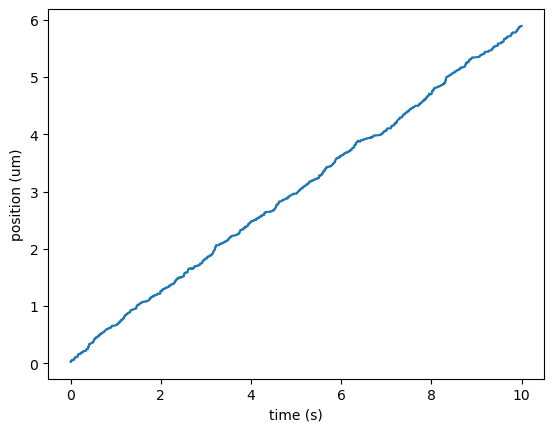

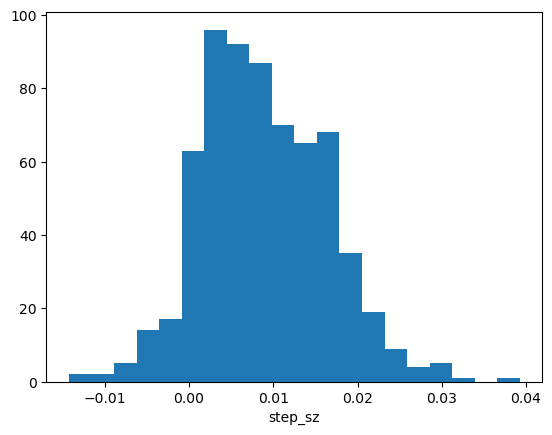

In [39]:
print('run len = ', np.round(rlen,2))
print('velocity = ', np.round(vel,2))

plt.plot(t,pos)
plt.xlabel('time (s)')
plt.ylabel('position (um)')
plt.show()

plt.hist(disp[disp[:]!=0],bins = 20)
plt.xlabel('step_sz')
plt.show()

In [40]:
"""
Time for some basic tests
"""

'\nTime for some basic tests\n'

In [41]:
#sing fil
n_hds = 4
n_states = 3
n_transitions = 3
rates = np.array([1300,700,6])
tfinal = 15
n_fil = 1
critical_indicies = np.array([0,2])
halfstep = 0.01

natp = 4
atps = [10,50,100,500]
#atps = np.logspace(1,3,natp)

ntrial = 6

vels = np.zeros((natp,ntrial))
rleng = np.zeros((natp,ntrial))

for aa in range(natp):
    ATP = atps[aa]
    print('atp = %s' %ATP)
    for tt in range(ntrial):
        #print('trial ',tt)
        #print('input_rate = ',rates[-1])
        pos,t,xlk,vel,disp,rlen,gamma = the_main_loop(n_hds,n_states,n_transitions,rates,ATP,tfinal,n_fil,critical_indicies,halfstep)
        vels[aa,tt] = vel
        rleng[aa,tt] = rlen

avv = np.mean(vels,axis = 1)
avr = np.nanmean(rleng,axis = 1)

stdv = np.std(vels,axis = 1)
stdr = np.std(rleng,axis = 1)

atp = 10


/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


atp = 50
atp = 100
atp = 500


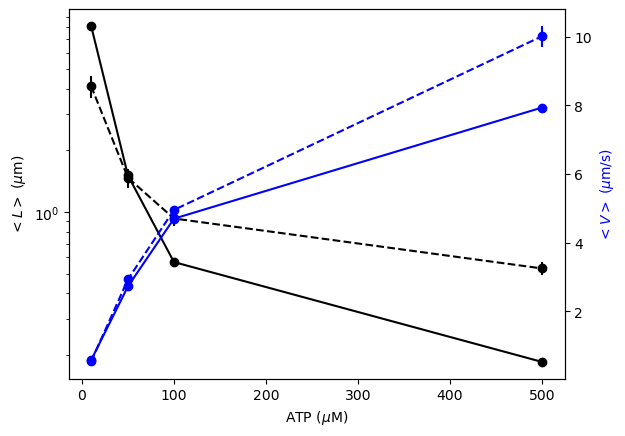

In [42]:
fig,ax = plt.subplots()
#ax.errorbar(atps, avr, stdr, fmt = 'k-o',label = 'simulation cont binding')
ax.plot(atps,avr,'k-o')
ax.set_ylabel('$<L>$ ($\mu$m)')
ax.set_yscale('log')
ax2=ax.twinx()
ax2.errorbar(atps, avv, stdv, fmt = 'b-o',label = 'simulation cont binding')
ax.errorbar(expt_atp, expt_run, erl_err, fmt = 'k--o',label = 'experiment')
#ax2.plot(atps,avv,'b-o')
ax.set_ylabel('$<L>$ ($\mu$m)')
#ax.set_yscale('log')
ax2.errorbar(expt_atp, expt_vel, ev_err, fmt = 'b--o',label = 'experiment')
ax.set_xlabel('ATP ($\mu$M)')
ax2.set_ylabel('$<V>$ ($\mu$m/s)', color='blue')
#ax2.set_yscale('log')
#ax.legend(fontsize = 9,loc = 2)
plt.show()

In [51]:
#2 fil
n_hds = 3
n_states = 3
n_transitions = 3
#rates = np.array([900,700,6])
#tfinal = 10
binding_increase = 5
n_fil = 2
critical_indicies = np.array([0,2])
halfstep = 0.01

natp = 8
#atps = [10,50,100,500]
atps = np.logspace(1,4,natp)

ntrial = 6

gamma = np.zeros((natp,ntrial))
xlk_prb = np.zeros((natp,ntrial))

for aa in range(natp):
    ATP = atps[aa]
    print('atp = %s' %ATP)
    for tt in range(ntrial):
        #print('trial ',tt)
        #print('input_rate = ',rates[-1])
        pos,t,xlk,vel,disp,rlen,gam = the_main_loop(n_hds,n_states,n_transitions,rates,ATP,tfinal,n_fil,critical_indicies,halfstep)
        gamma[aa,tt] = gam
        xlk_prb[aa,tt] = xlk

avxlk = np.mean(xlk_prb,axis = 1)
avgam = np.mean(gamma,axis = 1)

stdxlk = np.std(xlk_prb,axis = 1)
stdgam = np.std(gamma,axis = 1)

atp = 10.0
atp = 26.826957952797258
atp = 71.96856730011521
atp = 193.06977288832496
atp = 517.9474679231213
atp = 1389.4954943731375
atp = 3727.593720314938
atp = 10000.0


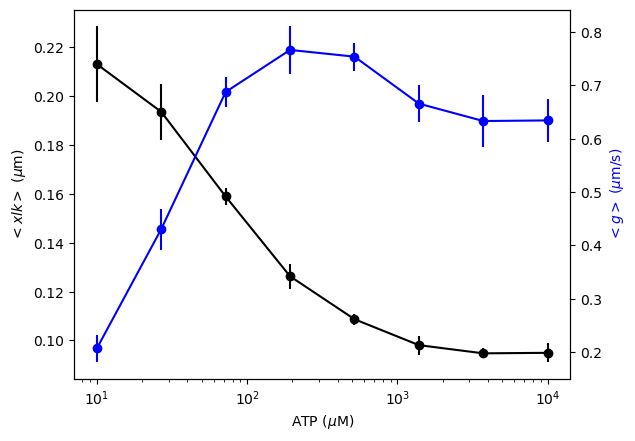

In [52]:
fig,ax = plt.subplots()
ax.errorbar(atps, avxlk, stdxlk, fmt = 'k-o',label = 'crosslinking ratio')
#ax.plot(atps,avr,'k-o')
ax.set_ylabel('$<xlk>$ ($\mu$m)')
ax.set_xscale('log')
ax2=ax.twinx()
ax2.errorbar(atps, avgam, stdgam, fmt = 'b-o',label = 'strain rate')
#ax.set_yscale('log')
ax.set_xlabel('ATP ($\mu$M)')
ax2.set_ylabel('$<g>$ ($\mu$m/s)', color='blue')
#ax2.set_yscale('log')
#ax.legend(fontsize = 9,loc = 2)
plt.show()

In [53]:
#get nematic equations
k = 0.1 + avxlk**1
a = avgam**(0.15)

v = np.sqrt(k*a)
l = np.sqrt(k/a)


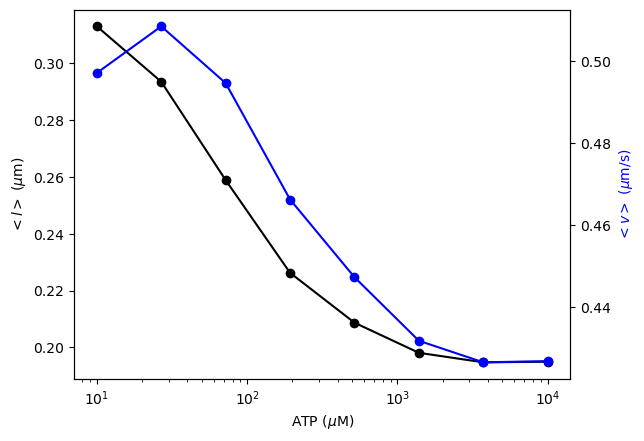

In [54]:

fig,ax = plt.subplots()
ax.plot(atps, k,'k-o')
ax.set_ylabel('$<l>$ ($\mu$m)')
ax.set_xscale('log')
ax2=ax.twinx()
ax2.plot(atps, v, 'b-o')
#ax.set_yscale('log')
ax.set_xlabel('ATP ($\mu$M)')
ax2.set_ylabel('$<v>$ ($\mu$m/s)', color='blue')
#ax.legend(fontsize = 9,loc = 2)
plt.show()

In [18]:
def plot_result(avr,avv):
    fig,ax = plt.subplots()
    ax.plot(atps, avr, 'k-o',label = 'simulation')
    ax.set_ylabel('$<L>$ ($\mu$m)')
    ax.set_yscale('log')
    ax2=ax.twinx()
    ax2.plot(atps, avv, 'b-o',label = 'simulation')
    ax.plot(atps, expt_run,'k--o',label = 'experiment')
    ax.set_ylabel('$<L>$ ($\mu$m)')
    ax.set_yscale('log')
    ax2.plot(atps, expt_vel,'b--o',label = 'experiment')
    ax.set_xlabel('ATP ($\mu$M)')
    ax2.set_ylabel('$<V>$ ($\mu$m/s)', color='blue')
    ax2.set_yscale('log')
    ax.legend(fontsize = 9,loc = 2)
    plt.show()

In [19]:
def quality_check(vels,runs,plot_res=False):
    
    vgood = np.sum(np.square((vels - expt_vel)))
    rgood = np.sum(np.square((runs - expt_run)/expt_run))
    
    if plot_res:
        plot_result(runs,vels)
    
    return rgood,vgood

In [20]:
def run_iter(n_hds,n_states,n_transitions,rates,ATP,tfinal,n_fil,critical_indicies,halfstep,plot_res):
    
    vels = np.zeros((natp,ntrial))
    rleng = np.zeros((natp,ntrial))

    for aa in range(natp):
        ATP = atps[aa]
        #print('atp = %s' %ATP)
        for tt in range(ntrial):
            #print('trial ',tt)
            #print('input_rate = ',rates[-1])
            pos,t,xlk,vel,disp,rlen,gamma = the_main_loop(n_hds,n_states,n_transitions,rates,ATP,tfinal,n_fil,critical_indicies,halfstep)
            vels[aa,tt] = vel
            rleng[aa,tt] = rlen

    avv = np.mean(vels,axis = 1)
    avr = np.nanmean(rleng,axis = 1)

    stdv = np.std(vels,axis = 1)
    stdr = np.std(rleng,axis = 1)

    rgood,vgood = quality_check(avv,avr,plot_res)
    return rgood,vgood

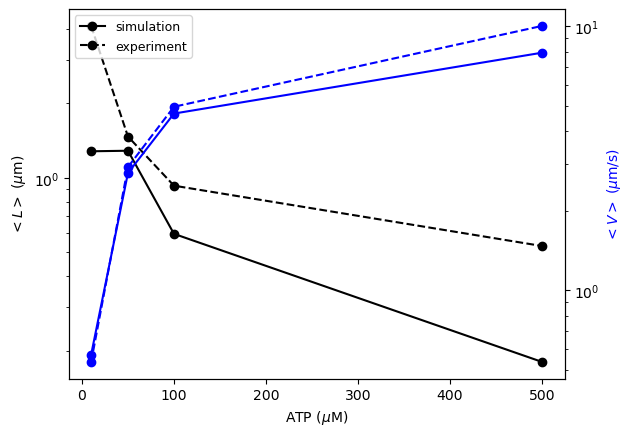

1.0569899162840852 4.441801218439594
options =  [1300  700    6]


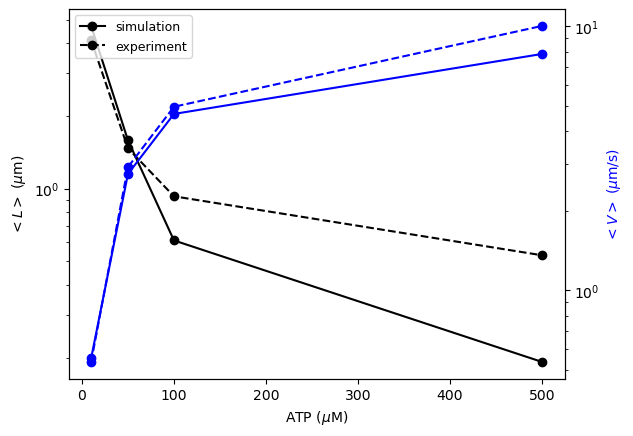

options =  [1300  700    6]
options =  [1300  700    6]


/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


options =  [1300  700    6]
options =  [1300  700    6]
accept
options =  [1231  700    6]
options =  [1231  700    6]
options =  [1292  700    6]
options =  [1292  700    6]
options =  [1292  665    6]
options =  [1292  665    6]
options =  [1292  631    6]
options =  [1292  631    6]
options =  [1292  662    6]
options =  [1292  662    6]
options =  [1292  695    6]
options =  [1292  695    6]
options =  [1356  695    6]
options =  [1356  695    6]
options =  [1356  695    5]
10
options =  [1356  695    5]


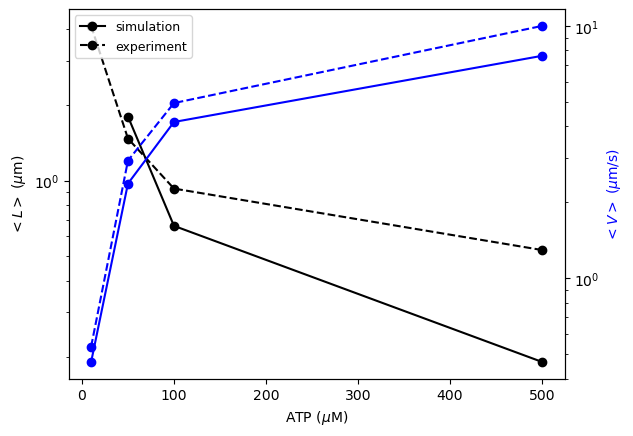

options =  [1288  695    5]
options =  [1288  695    5]
options =  [1352  695    5]
options =  [1352  695    5]
options =  [1419  695    5]
options =  [1419  695    5]
options =  [1419  660    5]
options =  [1419  660    5]
options =  [1419  660    4]
options =  [1419  660    4]
options =  [1419  693    4]
options =  [1419  693    4]
options =  [1348  693    4]
options =  [1348  693    4]
options =  [1280  693    4]
options =  [1280  693    4]
options =  [1344  693    4]
options =  [1344  693    4]
options =  [1276  693    4]
20
options =  [1276  693    4]


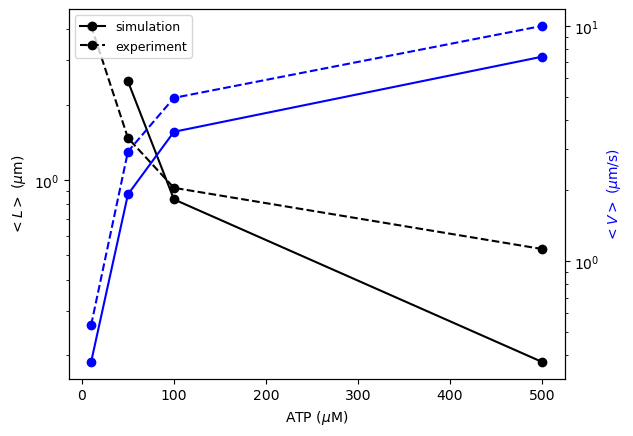

options =  [1212  693    4]
options =  [1212  693    4]
options =  [1212  658    4]
options =  [1212  658    4]
options =  [1151  658    4]
options =  [1151  658    4]
options =  [1151  625    4]
options =  [1151  625    4]
options =  [1151  625    3]
options =  [1151  625    3]
options =  [1208  625    3]
options =  [1208  625    3]
options =  [1208  625    2]
options =  [1208  625    2]
options =  [1147  625    2]
options =  [1147  625    2]
options =  [1147  625    1]
options =  [1147  625    1]
options =  [1147  625    0]
30
options =  [1147  625    0]


/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


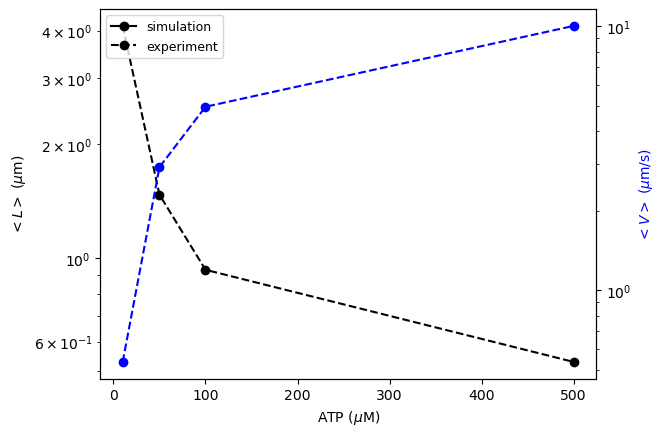

options =  [1147  593    0]
options =  [1147  593    0]
options =  [1147  622    0]
options =  [1147  622    0]
options =  [1089  622    0]
options =  [1089  622    0]
options =  [1089  622    0]
options =  [1089  622    0]
options =  [1089  590    0]
options =  [1089  590    0]
options =  [1143  590    0]
options =  [1143  590    0]
options =  [1143  619    0]
options =  [1143  619    0]
options =  [1200  619    0]
options =  [1200  619    0]
options =  [1140  619    0]
options =  [1140  619    0]
options =  [1140  619    0]
40
options =  [1140  619    0]


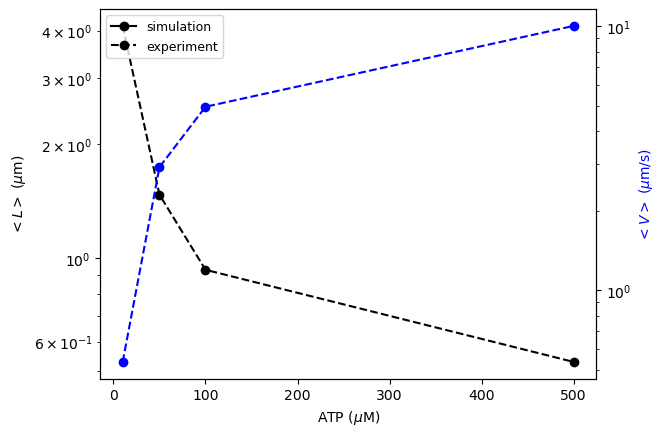

options =  [1140  619    0]
options =  [1140  619    0]
options =  [1140  619    0]
options =  [1140  619    0]
options =  [1140  619    0]
options =  [1140  619    0]
options =  [1140  619    0]
options =  [1140  619    0]
options =  [1197  619    0]
options =  [1197  619    0]
options =  [1197  619    0]
options =  [1197  619    0]
options =  [1197  619    0]
options =  [1197  619    0]
options =  [1197  619    0]
options =  [1197  619    0]
options =  [1197  588    0]
options =  [1197  588    0]
options =  [1137  588    0]
50
options =  [1137  588    0]


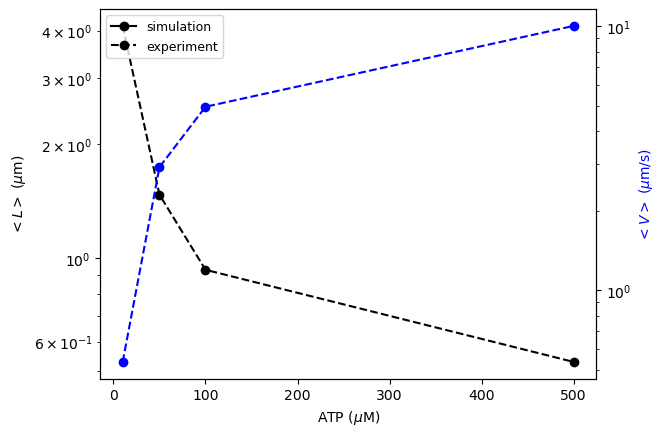

options =  [1193  588    0]
options =  [1193  588    0]
options =  [1252  588    0]
options =  [1252  588    0]
options =  [1252  588    0]
options =  [1252  588    0]
options =  [1189  588    0]
options =  [1189  588    0]
options =  [1189  588    0]
options =  [1189  588    0]
options =  [1129  588    0]
options =  [1129  588    0]
options =  [1185  588    0]
options =  [1185  588    0]
options =  [1185  617    0]
options =  [1185  617    0]
options =  [1185  647    0]
options =  [1185  647    0]
options =  [1185  679    0]
60
options =  [1185  679    0]


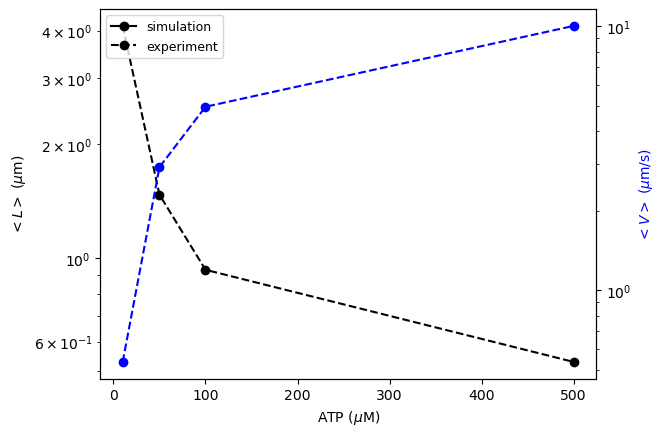

options =  [1185  679    0]
options =  [1185  679    0]
options =  [1185  712    0]
options =  [1185  712    0]
options =  [1125  712    0]
options =  [1125  712    0]
options =  [1125  676    0]
options =  [1125  676    0]
options =  [1125  676    0]
options =  [1125  676    0]
options =  [1125  676    0]
options =  [1125  676    0]
options =  [1125  676    0]
options =  [1125  676    0]
options =  [1181  676    0]
options =  [1181  676    0]
options =  [1181  642    0]
options =  [1181  642    0]
options =  [1181  642    0]
70
options =  [1181  642    0]


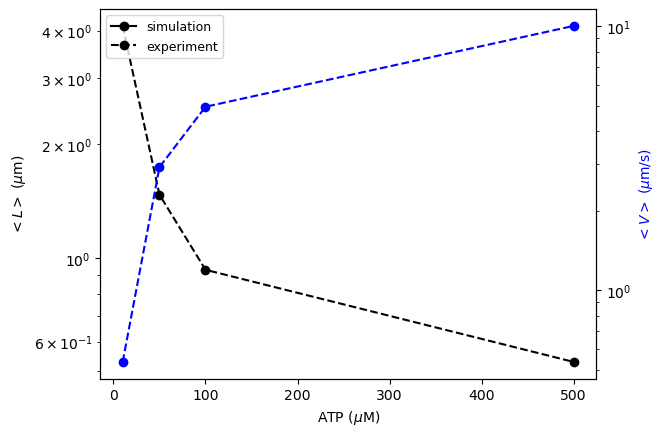

options =  [1240  642    0]
options =  [1240  642    0]
options =  [1178  642    0]
options =  [1178  642    0]
options =  [1178  674    0]
options =  [1178  674    0]
options =  [1236  674    0]
options =  [1236  674    0]
options =  [1236  640    0]
options =  [1236  640    0]
options =  [1174  640    0]
options =  [1174  640    0]
options =  [1174  672    0]
options =  [1174  672    0]
options =  [1115  672    0]
options =  [1115  672    0]
options =  [1115  672    0]
options =  [1115  672    0]
options =  [1115  672    0]
80
options =  [1115  672    0]


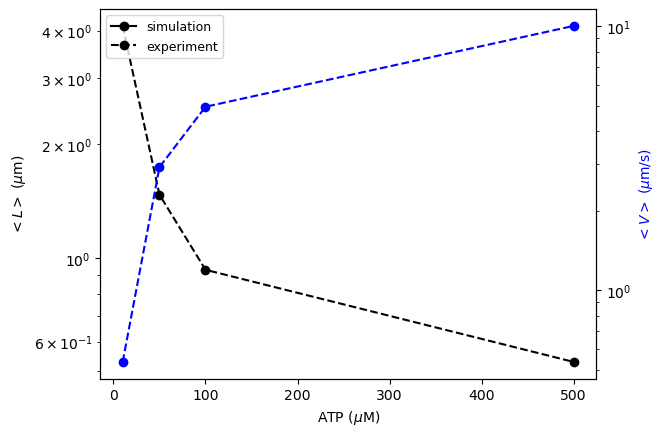

options =  [1170  672    0]
options =  [1170  672    0]
options =  [1170  638    0]
options =  [1170  638    0]
options =  [1170  638    0]
options =  [1170  638    0]
options =  [1170  669    0]
options =  [1170  669    0]
options =  [1170  669    0]
options =  [1170  669    0]
options =  [1170  669    0]
options =  [1170  669    0]
options =  [1228  669    0]
options =  [1228  669    0]
options =  [1228  635    0]
options =  [1228  635    0]
options =  [1228  635    0]
options =  [1228  635    0]
options =  [1228  635    0]
90
options =  [1228  635    0]


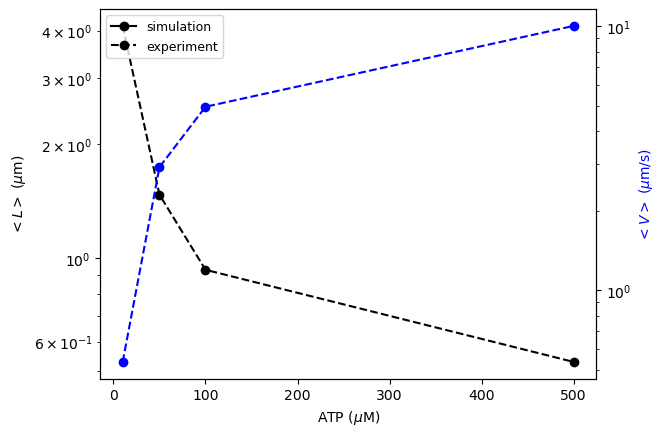

options =  [1289  635    0]
options =  [1289  635    0]
options =  [1224  635    0]
options =  [1224  635    0]
options =  [1285  635    0]
options =  [1285  635    0]
options =  [1285  635    0]
options =  [1285  635    0]
options =  [1285  603    0]
options =  [1285  603    0]
options =  [1349  603    0]
options =  [1349  603    0]
options =  [1349  633    0]
options =  [1349  633    0]
options =  [1349  633    0]
options =  [1349  633    0]
options =  [1349  664    0]
options =  [1349  664    0]
options =  [1349  697    0]
100
acceptance probability =  0.01


In [29]:
naccept = 0
nreject = 0



options = np.array([1300,700,6])
temp_options = np.zeros(3)
n_hds = 4
n_states = 3
n_transitions = 3
tfinal = 15
n_fil = 1
critical_indicies = np.array([0,2])
halfstep = 0.01
natp = 4
atps = [10,50,100,500]

temp_options = options.copy()

err = []

current_r, current_v = run_iter(n_hds,n_states,n_transitions,temp_options,ATP,tfinal,n_fil,critical_indicies,halfstep,True)
print(current_r,current_v)

niter = 100

nn = 0

while nn < niter:

    if nn%10==0:
        plot_res = True
    else:
        plot_res = False
    
    #propose step
    choice = int(np.floor(np.random.rand()*np.size(temp_options)))
    #change by 5 percent each time
    temp_options[choice] = temp_options[choice] + (np.round(np.random.rand())*2 - 1)*temp_options[choice]/20
    
    
    temp_r, temp_v = run_iter(n_hds,n_states,n_transitions,temp_options,ATP,tfinal,n_fil,critical_indicies,halfstep,plot_res)
    
    
    if ((np.sum(temp_r) < np.sum(current_r)) and (np.sum(temp_v) < np.sum(current_v))):
        current_r = temp_r
        current_v = temp_v
        options = temp_options
        naccept +=1
        print('accept')
    else:
        nreject +=1
        
    print('temp options = ',temp_options)
    err.append(np.sum(current_r)+np.sum(current_v))
    nn+=1
    
    if nn%10==0:
        print(nn)
        np.savetxt('/home/redford/data_arrays/optimal_params_3state_stochastic_and_051123.txt',options)
        np.savetxt('/home/redford/data_arrays/err_3state_stochastic_and_051123.txt',err)
    
print('acceptance probability = ',naccept/niter)

In [25]:
int(np.round(np.random.rand())) + 1

1